---
title: Linear Regression
subtitle: Bikeshare in DC
date: 2025-02-19
from: markdown+emoji
execute: 
  eval: false
---

# Settings

## Required Libraries and Spark Session

In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate  # for table summary
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # for lowess smoothing

from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, avg, when, log, sqrt, exp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

spark = SparkSession.builder.master("local[*]").getOrCreate()

## UDFs

### regression_table

In [ ]:
#| code-fold: true
def regression_table(model, assembler):
    """
    Creates a formatted regression table from a fitted LinearRegression model and its VectorAssembler.

    If the model’s labelCol (retrieved using getLabelCol()) starts with "log", an extra column showing np.exp(coeff)
    is added immediately after the beta estimate column for predictor rows. Additionally, np.exp() of the 95% CI
    Lower and Upper bounds is also added unless the predictor's name includes "log_". The Intercept row does not
    include exponentiated values.

    When labelCol starts with "log", the columns are ordered as:
        y: [label] | Beta | Exp(Beta) | Sig. | Std. Error | p-value | 95% CI Lower | Exp(95% CI Lower) | 95% CI Upper | Exp(95% CI Upper)

    Otherwise, the columns are:
        y: [label] | Beta | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper

    Parameters:
        model: A fitted LinearRegression model (with a .summary attribute and a labelCol).
        assembler: The VectorAssembler used to assemble the features for the model.

    Returns:
        A formatted string containing the regression table.
    """
    # Determine if we should display exponential values for coefficients.
    is_log = model.getLabelCol().lower().startswith("log")

    # Extract coefficients and standard errors as NumPy arrays.
    coeffs = model.coefficients.toArray()
    std_errors_all = np.array(model.summary.coefficientStandardErrors)

    # Check if the intercept's standard error is included (one extra element).
    if len(std_errors_all) == len(coeffs) + 1:
        intercept_se = std_errors_all[0]
        std_errors = std_errors_all[1:]
    else:
        intercept_se = None
        std_errors = std_errors_all

    # Use provided tValues and pValues.
    df = model.summary.numInstances - len(coeffs) - 1
    t_critical = stats.t.ppf(0.975, df)
    p_values = model.summary.pValues

    # Helper: significance stars.
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build table rows for each feature.
    table = []
    for feature, beta, se, p in zip(assembler.getInputCols(), coeffs, std_errors, p_values):
        ci_lower = beta - t_critical * se
        ci_upper = beta + t_critical * se

        # Check if predictor contains "log_" to determine if exponentiation should be applied
        apply_exp = is_log and "log_" not in feature.lower()

        exp_beta = np.exp(beta) if apply_exp else ""
        exp_ci_lower = np.exp(ci_lower) if apply_exp else ""
        exp_ci_upper = np.exp(ci_upper) if apply_exp else ""

        if is_log:
            table.append([
                feature,            # Predictor name
                beta,               # Beta estimate
                exp_beta,           # Exponential of beta (or blank)
                significance_stars(p),
                se,
                p,
                ci_lower,
                exp_ci_lower,       # Exponential of 95% CI lower bound
                ci_upper,
                exp_ci_upper        # Exponential of 95% CI upper bound
            ])
        else:
            table.append([
                feature,
                beta,
                significance_stars(p),
                se,
                p,
                ci_lower,
                ci_upper
            ])

    # Process intercept.
    if intercept_se is not None:
        intercept_p = model.summary.pValues[0] if model.summary.pValues is not None else None
        intercept_sig = significance_stars(intercept_p)
        ci_intercept_lower = model.intercept - t_critical * intercept_se
        ci_intercept_upper = model.intercept + t_critical * intercept_se
    else:
        intercept_sig = ""
        ci_intercept_lower = ""
        ci_intercept_upper = ""
        intercept_se = ""

    if is_log:
        table.append([
            "Intercept",
            model.intercept,
            "",                    # Removed np.exp(model.intercept)
            intercept_sig,
            intercept_se,
            "",
            ci_intercept_lower,
            "",
            ci_intercept_upper,
            ""
        ])
    else:
        table.append([
            "Intercept",
            model.intercept,
            intercept_sig,
            intercept_se,
            "",
            ci_intercept_lower,
            ci_intercept_upper
        ])

    # Append overall model metrics.
    if is_log:
        table.append(["Observations", model.summary.numInstances, "", "", "", "", "", "", "", ""])
        table.append(["R²", model.summary.r2, "", "", "", "", "", "", "", ""])
        table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", "", "", "", ""])
    else:
        table.append(["Observations", model.summary.numInstances, "", "", "", "", ""])
        table.append(["R²", model.summary.r2, "", "", "", "", ""])
        table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", ""])

    # Format the table rows.
    formatted_table = []
    for row in table:
        formatted_row = []
        for i, item in enumerate(row):
            # Format Observations as integer with commas.
            if row[0] == "Observations" and i == 1 and isinstance(item, (int, float, np.floating)) and item != "":
                formatted_row.append(f"{int(item):,}")
            elif isinstance(item, (int, float, np.floating)) and item != "":
                if is_log:
                    # When is_log, the columns are:
                    # 0: Metric, 1: Beta, 2: Exp(Beta), 3: Sig, 4: Std. Error, 5: p-value,
                    # 6: 95% CI Lower, 7: Exp(95% CI Lower), 8: 95% CI Upper, 9: Exp(95% CI Upper).
                    if i in [1, 2, 4, 6, 7, 8, 9]:
                        formatted_row.append(f"{item:,.3f}")
                    elif i == 5:
                        formatted_row.append(f"{item:.3f}")
                    else:
                        formatted_row.append(f"{item:.3f}")
                else:
                    # When not is_log, the columns are:
                    # 0: Metric, 1: Beta, 2: Sig, 3: Std. Error, 4: p-value, 5: 95% CI Lower, 6: 95% CI Upper.
                    if i in [1, 3, 5, 6]:
                        formatted_row.append(f"{item:,.3f}")
                    elif i == 4:
                        formatted_row.append(f"{item:.3f}")
                    else:
                        formatted_row.append(f"{item:.3f}")
            else:
                formatted_row.append(item)
        formatted_table.append(formatted_row)

    # Set header and column alignment based on whether label starts with "log"
    if is_log:
        headers = [
            f"y: {model.getLabelCol()}",
            "Beta", "Exp(Beta)", "Sig.", "Std. Error", "p-value",
            "95% CI Lower", "Exp(95% CI Lower)", "95% CI Upper", "Exp(95% CI Upper)"
        ]
        colalign = ("left", "right", "right", "center", "right", "right", "right", "right", "right", "right")
    else:
        headers = [f"y: {model.getLabelCol()}", "Beta", "Sig.", "Std. Error", "p-value", "95% CI Lower", "95% CI Upper"]
        colalign = ("left", "right", "center", "right", "right", "right", "right")

    table_str = tabulate(
        formatted_table,
        headers=headers,
        tablefmt="pretty",
        colalign=colalign
    )

    # Insert a dashed line after the Intercept row.
    lines = table_str.split("\n")
    dash_line = '-' * len(lines[0])
    for i, line in enumerate(lines):
        if "Intercept" in line and not line.strip().startswith('+'):
            lines.insert(i+1, dash_line)
            break

    return "\n".join(lines)

# Example usage:
# print(regression_table(model_1, assembler_1))

### add_dummy_variables

In [ ]:
#| code-fold: true
def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


# Example usage without category_order:
# dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)

# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

### residual_plot

In [ ]:
#| code-fold: true
def residual_plot(df, label_col, model_name):
    """
    Generates a residual plot for a given test dataframe.

    Parameters:
        df (DataFrame): Spark DataFrame containing the test set with predictions.
        label_col (str): The column name of the actual outcome variable.
        title (str): The title for the residual plot.

    Returns:
        None (displays the plot)
    """
    # Convert to Pandas DataFrame
    df_pd = df.select(["prediction", label_col]).toPandas()
    df_pd["residual"] = df_pd[label_col] - df_pd["prediction"]

    # Scatter plot of residuals vs. predicted values
    plt.scatter(df_pd["prediction"], df_pd["residual"], alpha=0.2, color="darkgray")

    # Use LOWESS smoothing for trend line
    smoothed = sm.nonparametric.lowess(df_pd["residual"], df_pd["prediction"])
    plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue")

    # Add reference line at y=0
    plt.axhline(y=0, color="red", linestyle="--")

    # Labels and title (model_name)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    model_name = "Residual Plot for " + model_name
    plt.title(model_name)

    # Show plot
    plt.show()

# Example usage:
# residual_plot(dtest_1, "log_sales", "Model 1")

# Data Preparation

## Spark DataFrame

In [ ]:
# 1. Read CSV data from URL
df_pd = pd.read_csv('https://bcdanl.github.io/data/bikeshare_cleaned.csv')
df = spark.createDataFrame(df_pd)
df.show()

+---+----+-----+----+---+--------+-------+-------+--------------------+------------------+-----------------+------------------+
|cnt|year|month|date| hr|   wkday|holiday|seasons|        weather_cond|              temp|              hum|         windspeed|
+---+----+-----+----+---+--------+-------+-------+--------------------+------------------+-----------------+------------------+
| 16|2011|    1|   1|  0|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.947345243330896|  -1.5538438052971|
| 40|2011|    1|   1|  1|saturday|      0| spring| Clear or Few Cloudy| -1.43847500990342|0.895512927978679|  -1.5538438052971|
| 32|2011|    1|   1|  2|saturday|      0| spring| Clear or Few Cloudy| -1.43847500990342|0.895512927978679|  -1.5538438052971|
| 13|2011|    1|   1|  3|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.636351351217591|  -1.5538438052971|
|  1|2011|    1|   1|  4|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.636351351217

## Training-Test Split

In [ ]:
dtrain, dtest = df.randomSplit([0.6, 0.4], seed = 1234)

## Adding Dummies

In [ ]:
dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)
dummy_cols_month, ref_category_month = add_dummy_variables('month', 0)
dummy_cols_hr, ref_category_hr = add_dummy_variables('hr', 0)

custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday'] # Custom category_order
dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

dummy_cols_holiday, ref_category_holiday = add_dummy_variables('holiday', 0)

custom_order_seasons = ['spring', 'summer', 'fall', 'winter']  # Custom category_order
dummy_cols_seasons, ref_category_seasons = add_dummy_variables('seasons', 0, custom_order_seasons)

dummy_cols_weather_cond, ref_category_weather_cond = add_dummy_variables('weather_cond', 0)


Reference category (dummy omitted): 2011
Reference category (dummy omitted): 1
Reference category (dummy omitted): 0
Reference category (dummy omitted): sunday
Reference category (dummy omitted): 0
Reference category (dummy omitted): spring
Reference category (dummy omitted): Clear or Few Cloudy


# Model

## Assembling Predictors

In [ ]:
conti_cols = ["temp", "hum", "windspeed"]
assembler_predictors = (
    conti_cols +
    dummy_cols_year + dummy_cols_month +
    dummy_cols_hr + dummy_cols_wkday +
    dummy_cols_holiday + dummy_cols_seasons + dummy_cols_weather_cond
)

assembler_dum = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)
dtrain_dum = assembler_dum.transform(dtrain)
dtest_dum  = assembler_dum.transform(dtest)

## Fitting Regression

In [ ]:
model_dum = (
    LinearRegression(featuresCol="predictors",
                     labelCol="cnt")
    .fit(dtrain_dum)
)

## Regression Table

In [ ]:
print( regression_table(model_dum, assembler_dum) )

+---------------------------------------+---------+------+------------+---------+--------------+--------------+
| y: cnt                                |    Beta | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+---------------------------------------+---------+------+------------+---------+--------------+--------------+
| temp                                  |  45.307 | ***  |      1.395 |   0.000 |       42.573 |       48.042 |
| hum                                   | -17.193 | ***  |      1.095 |   0.000 |      -19.339 |      -15.046 |
| windspeed                             |  -4.617 | ***  |      2.029 |   0.000 |       -8.595 |       -0.639 |
| year_2012                             |  85.361 | ***  |      5.129 |   0.000 |       75.308 |       95.414 |
| month_2                               |   8.508 |  *   |      5.765 |   0.097 |       -2.792 |       19.809 |
| month_3                               |  18.322 | ***  |      8.557 |   0.001 |        1.550 |       3

## Making Predictions

In [ ]:
dtest_dum = model_dum.transform(dtest_dum)

## Coefficient Plots

### Pandas DataFrame for the Plots




In [ ]:
terms = assembler_dum.getInputCols()
coefs = model_dum.coefficients.toArray()[:len(terms)]
stdErrs = model_dum.summary.coefficientStandardErrors[:len(terms)]

df_summary = pd.DataFrame({
    "term": terms,
    "estimate": coefs,
    "std_error": stdErrs
})

### `temp`, `hum` and `windspeed` variables.

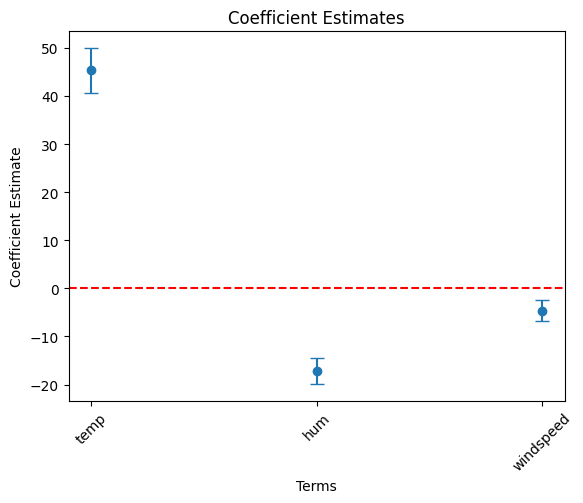

In [ ]:
# Filter df_summary if needed
cond = df_summary['term'].isin(['temp', 'hum', 'windspeed'])

df_summary_1 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_1["term"], df_summary_1["estimate"],
             yerr = 1.96 * df_summary_1["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

### `month` variables.

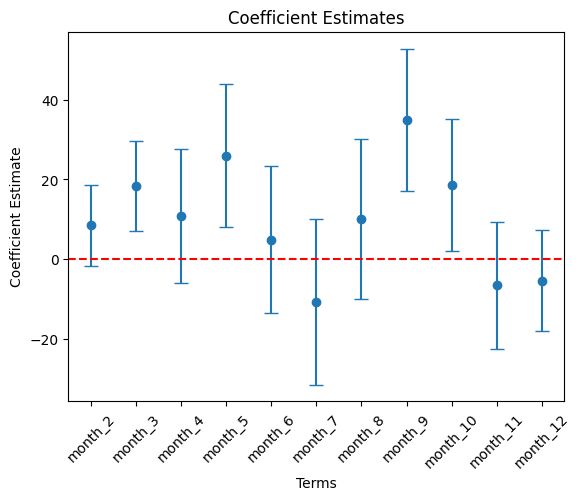

In [ ]:
# Filter df_summary if needed
month_list = ['month_' + str(i) for i in range(2, 13)]
cond = df_summary['term'].isin( month_list )

df_summary_2 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_2["term"], df_summary_2["estimate"],
             yerr = 1.96 * df_summary_2["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

### `hr` variables

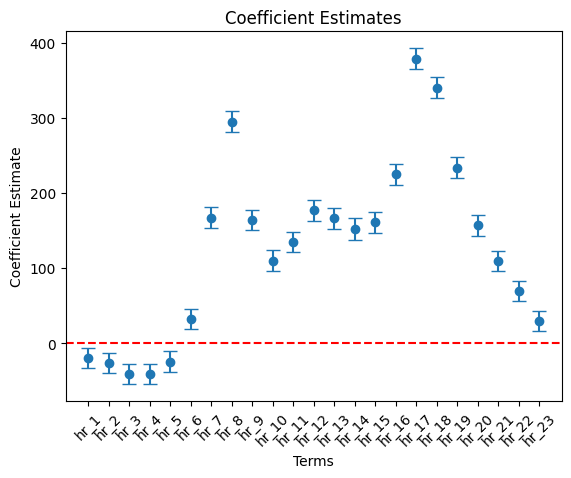

In [ ]:
# Filter df_summary if needed
hr_list = ['hr_' + str(i) for i in range(1, 25)]
cond = df_summary['term'].isin( hr_list )

df_summary_3 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_3["term"], df_summary_3["estimate"],
             yerr = 1.96 * df_summary_3["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

### `wkday` variables

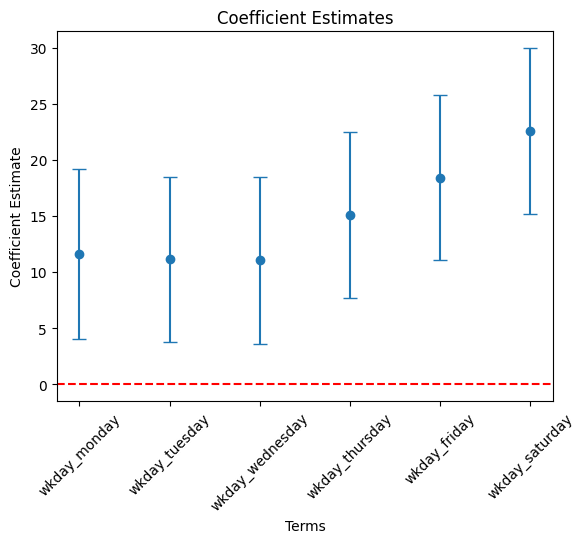

In [ ]:
# Filter df_summary if needed
wkday_list = [ 'wkday_' + day for day in ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday'] ]
cond = df_summary['term'].isin( wkday_list )
df_summary_4 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_4["term"], df_summary_4["estimate"],
             yerr = 1.96 * df_summary_4["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

- Draw a coefficient plot for seasons variables.

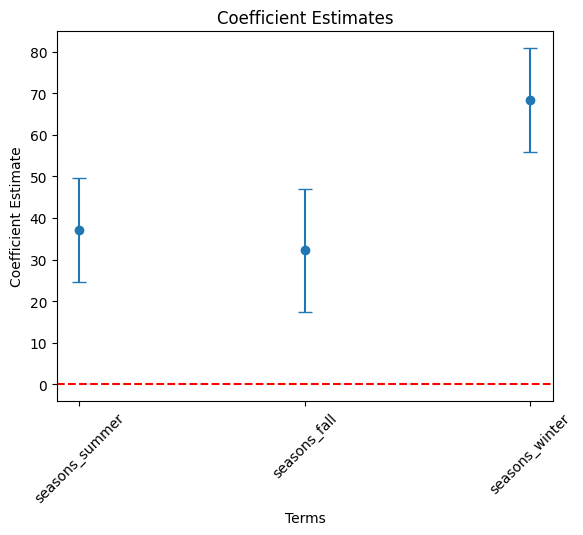

In [ ]:
# Filter df_summary if needed
seasons_list = [ 'seasons_' + s for s in ['summer', 'fall', 'winter'] ]
cond = df_summary['term'].isin( seasons_list )
df_summary_5 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_5["term"], df_summary_5["estimate"],
             yerr = 1.96 * df_summary_5["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()


- Draw a coefficient plot for weather_cond variables.

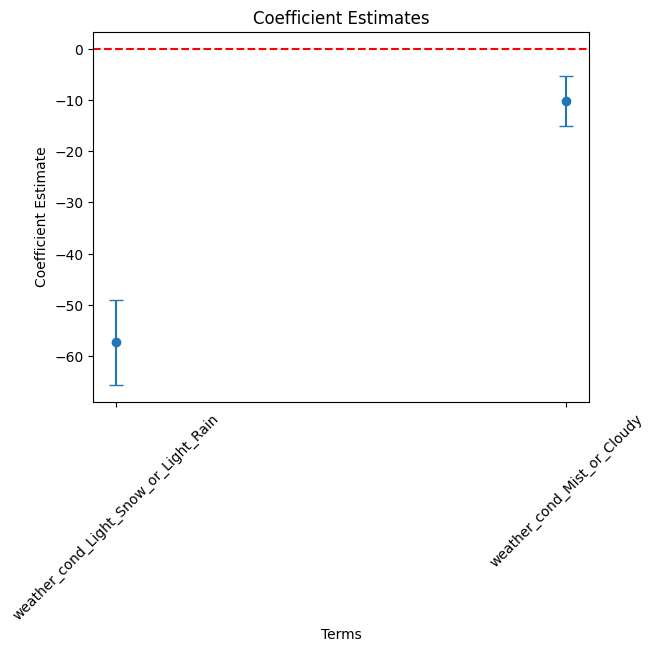

In [ ]:
# Filter df_summary if needed
weather_cond_list = [ 'weather_cond_' + s for s in ['Light_Snow_or_Light_Rain', 'Mist_or_Cloudy'] ]
cond = df_summary['term'].isin( weather_cond_list )
df_summary_6 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_6["term"], df_summary_6["estimate"],
             yerr = 1.96 * df_summary_6["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

## Residual Plot

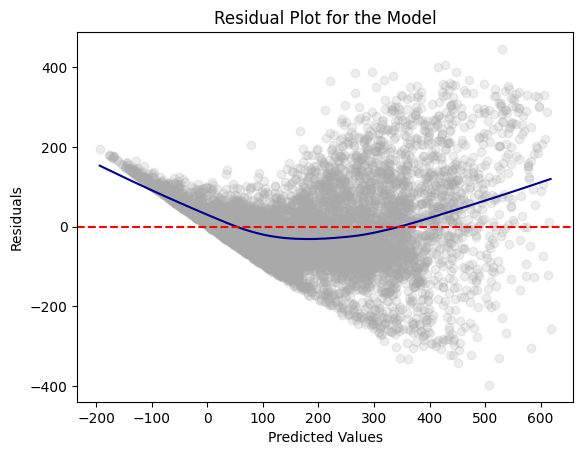

In [ ]:
residual_plot(dtest_dum, "cnt", "the Model")

## RMSE

In [ ]:
dtest_dum = dtest_dum.withColumn("error_sq", pow(col('cnt') - col('prediction'), 2))
rmse_dum = dtest_dum.agg(sqrt(avg("error_sq")).alias("rmse")).collect()[0]["rmse"]
rmse_dum

101.18558392860682

# Log of `cnt`

In [ ]:
df = df.withColumn("log_cnt", log( df['cnt'] ) )
df.show()

+---+----+-----+----+---+--------+-------+-------+--------------------+------------------+-----------------+------------------+------------------+
|cnt|year|month|date| hr|   wkday|holiday|seasons|        weather_cond|              temp|              hum|         windspeed|           log_cnt|
+---+----+-----+----+---+--------+-------+-------+--------------------+------------------+-----------------+------------------+------------------+
| 16|2011|    1|   1|  0|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.947345243330896|  -1.5538438052971| 2.772588722239781|
| 40|2011|    1|   1|  1|saturday|      0| spring| Clear or Few Cloudy| -1.43847500990342|0.895512927978679|  -1.5538438052971|3.6888794541139363|
| 32|2011|    1|   1|  2|saturday|      0| spring| Clear or Few Cloudy| -1.43847500990342|0.895512927978679|  -1.5538438052971|3.4657359027997265|
| 13|2011|    1|   1|  3|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.636351351217591|  -1.55384

# Histograms

##  `cnt`

<Axes: xlabel='cnt', ylabel='Count'>

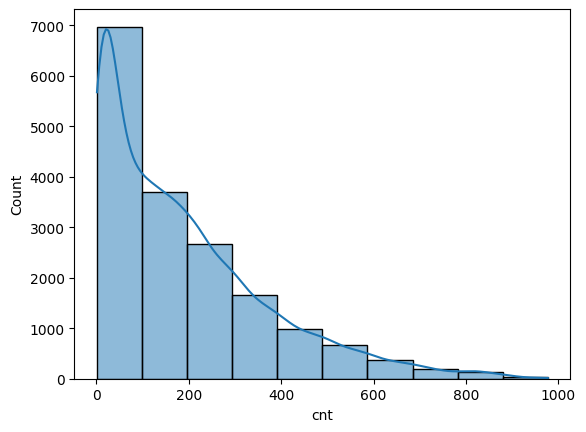

In [ ]:
# Create a histogram
dfpd = df.select(["cnt"]).toPandas()
sns.histplot(dfpd["cnt"], bins=10, kde=True)

## `log_cnt`

<Axes: xlabel='log_cnt', ylabel='Count'>

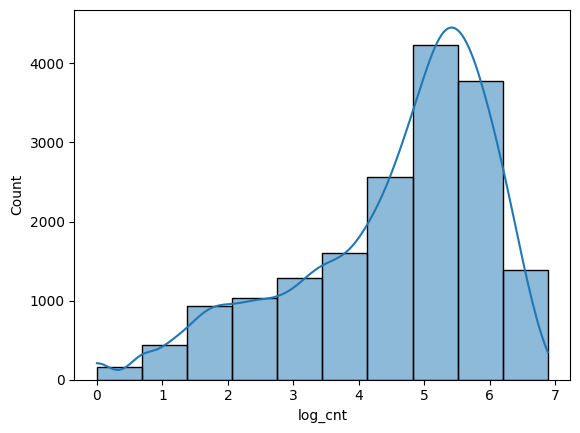

In [ ]:
# Create a histogram
dfpd = df.select(["log_cnt"]).toPandas()
sns.histplot(dfpd["log_cnt"], bins=10, kde=True)

# Model with Log-Outcome Variable

## Data Preparation

### Training-Test Split

In [ ]:
dtrain, dtest = df.randomSplit([0.6, 0.4], seed = 1234)

### Adding Dummies

In [ ]:
dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)
dummy_cols_month, ref_category_month = add_dummy_variables('month', 0)
dummy_cols_hr, ref_category_hr = add_dummy_variables('hr', 0)

custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday'] # Custom category_order
dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

dummy_cols_holiday, ref_category_holiday = add_dummy_variables('holiday', 0)

custom_order_seasons = ['spring', 'summer', 'fall', 'winter'] # Custom category_order
dummy_cols_seasons, ref_category_seasons = add_dummy_variables('seasons', 0, custom_order_seasons)

dummy_cols_weather_cond, ref_category_weather_cond = add_dummy_variables('weather_cond', 0)

Reference category (dummy omitted): 2011
Reference category (dummy omitted): 1
Reference category (dummy omitted): 0
Reference category (dummy omitted): sunday
Reference category (dummy omitted): 0
Reference category (dummy omitted): spring
Reference category (dummy omitted): Clear or Few Cloudy


## Assembling Predictors

In [ ]:
conti_cols = ["temp", "hum", "windspeed"]
assembler_predictors = (
    conti_cols +
    dummy_cols_year + dummy_cols_month +
    dummy_cols_hr + dummy_cols_wkday +
    dummy_cols_holiday + dummy_cols_seasons + dummy_cols_weather_cond
)

assembler_log = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)
dtrain_log = assembler_log.transform(dtrain)
dtest_log  = assembler_log.transform(dtest)

## Fitting Regression

In [ ]:
model_log = (
    LinearRegression(featuresCol="predictors",
                     labelCol="log_cnt")
    .fit(dtrain_log)
)

## Regression Table

In [ ]:
print( regression_table(model_log, assembler_log) )

+---------------------------------------+--------+-----------+------+------------+---------+--------------+-------------------+--------------+-------------------+
| y: log_cnt                            |   Beta | Exp(Beta) | Sig. | Std. Error | p-value | 95% CI Lower | Exp(95% CI Lower) | 95% CI Upper | Exp(95% CI Upper) |
+---------------------------------------+--------+-----------+------+------------+---------+--------------+-------------------+--------------+-------------------+
| temp                                  |  0.271 |     1.311 | ***  |      0.008 |   0.000 |        0.254 |             1.290 |        0.288 |             1.333 |
| hum                                   | -0.056 |     0.946 | ***  |      0.007 |   0.000 |       -0.069 |             0.933 |       -0.043 |             0.958 |
| windspeed                             | -0.028 |     0.972 | ***  |      0.012 |   0.000 |       -0.053 |             0.949 |       -0.004 |             0.996 |
| year_2012           

## Making Predictions

In [ ]:
dtest_log = model_log.transform(dtest_log)

## Coefficient Plots

### Pandas DataFrame for the Plots

In [ ]:
terms = assembler_log.getInputCols()
coefs = model_log.coefficients.toArray()[:len(terms)]
stdErrs = model_log.summary.coefficientStandardErrors[:len(terms)]

df_summary = pd.DataFrame({
    "term": terms,
    "estimate": coefs,
    "std_error": stdErrs
})

### `temp`, `hum` and `windspeed` variables.

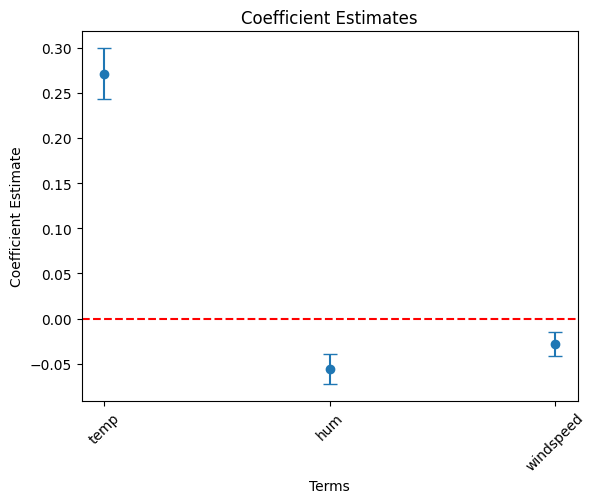

In [ ]:
# Filter df_summary if needed
cond = df_summary['term'].isin(['temp', 'hum', 'windspeed'])

df_summary_1 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_1["term"],
             df_summary_1["estimate"],
             yerr = 1.96 * df_summary_1["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

### `month` variables.

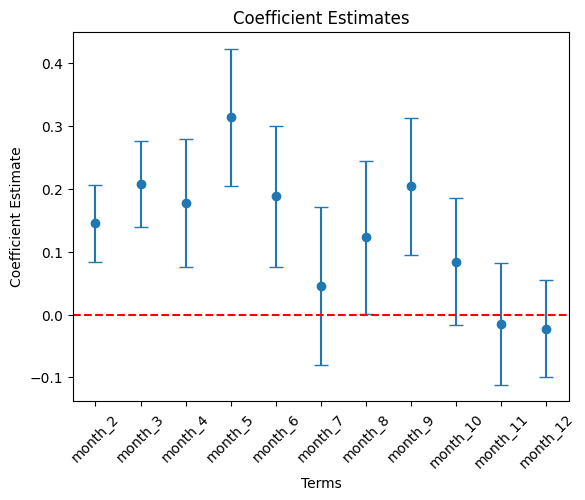

In [ ]:
# Filter df_summary if needed
month_list = ['month_' + str(i) for i in range(2, 13)]
cond = df_summary['term'].isin( month_list )

df_summary_2 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_2["term"], df_summary_2["estimate"],
             yerr = 1.96 * df_summary_2["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

### `hr` variables

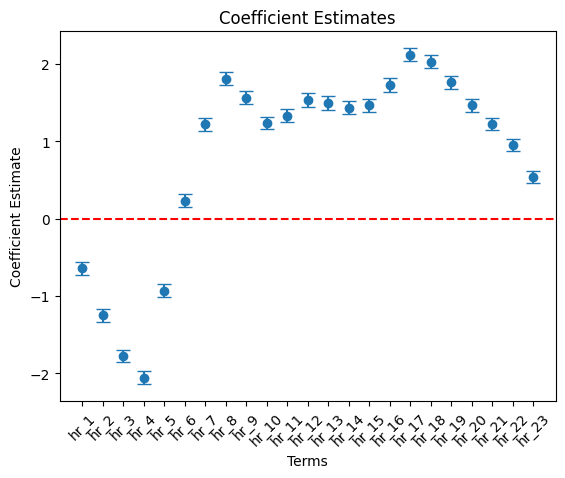

In [ ]:
# Filter df_summary if needed
hr_list = ['hr_' + str(i) for i in range(1, 25)]
cond = df_summary['term'].isin( hr_list )

df_summary_3 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_3["term"], df_summary_3["estimate"],
             yerr = 1.96 * df_summary_3["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

### `wkday` variables

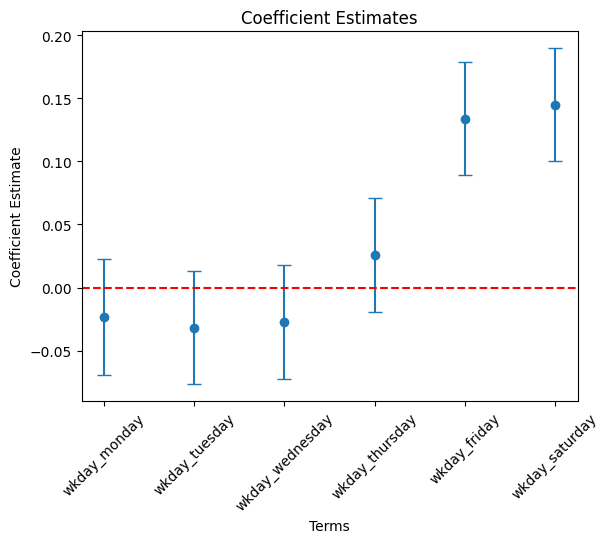

In [ ]:
# Filter df_summary if needed
wkday_list = [ 'wkday_' + day for day in ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday'] ]
cond = df_summary['term'].isin( wkday_list )
df_summary_4 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_4["term"], df_summary_4["estimate"],
             yerr = 1.96 * df_summary_4["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

## Residual Plot

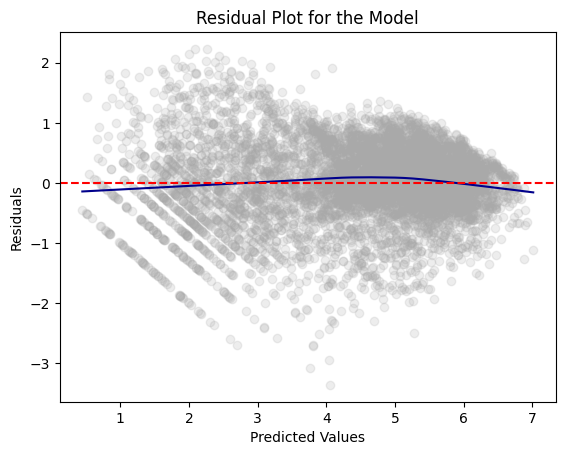

In [ ]:
residual_plot(dtest_log, "log_cnt", "the Model")

## RMSE

In [ ]:
dtest_log = dtest_log.withColumn("error_sq", pow(col('log_cnt') - col('prediction'), 2))
rmse_log = dtest_log.agg(sqrt(avg("error_sq")).alias("rmse")).collect()[0]["rmse"]
rmse_log

0.6288655799916469

In [ ]:
# transform fitted log_cnt to fitted cnt
dtest_log = dtest_log.withColumn("prediction_cnt", exp(col('prediction')))

In [ ]:
dtest_log = dtest_log.withColumn("error_sq_transform", pow(col('cnt') - col('prediction_cnt'), 2))
rmse_log = dtest_log.agg(sqrt(avg("error_sq_transform")).alias("rmse")).collect()[0]["rmse"]
rmse_log

98.60168448259316